# EE5213/CS623 Assignment 2 - Part B - CNN

Before we start, please put your name and LUMS ID(8 digit) in the following cell.

In [1]:
rollnumber = 21100171
name = "Muhammad Sameer"

### Instructions (IMPORTANT)

When completing the notebook, please adhere to the following rules:
- Do not write or modify any code outside of code blocks. (You can make copy of the notebook if you want to play with the code, but for the notebook you submit the code should remain un-modified).

```python
########### WRITE YOUR CODE BELOW ######

print("Hello World")

########### END OF CODE ###############
```

- Do not add or delete any cells from the notebook. You may add new cells to perform scatch work, but delete them before submitting.
- Run all cells before submitting. You will only get credit for code that has been run (for the output that has been shown in this notebook).

# MALE/FEMALE Image Classification with Flickr Dataset

In Part A we saw that the a simple neural network design with only dense layer was able to achieve high accuracy without the use of any convolutional layer.

Examining the kaggle dataset from part A, we can observe that all the images are tight crops of the faces such that the major features such as eyes, nose etc are approximately at the same location in each image. Recall from the lecture that dense layers can work well in this scenario where the locations of the features in the image don't change.

In Part B, we make the problem slightly more challenging. We are going to use two different datasets; one for the training the model and one for testing the model. Training set is the same kaggle datset which we used in Part A, but for testing we use a subset of images from Flicker-Faces-HQ dataset (https://github.com/NVlabs/ffhq-dataset).

You will notice later in the notebook that the images from this dataset are not as tight a crop of the face with some of the background visible around the face. As a result the location of face and facial features in the image changes somewhat from image to image.

# Environment Setup

Importing packages

In [2]:
import os
import random
import numpy as np
import tensorflow as tf
from matplotlib import pyplot
import matplotlib.pyplot as plt
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten,MaxPooling2D
from skimage.io import imread_collection
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

Run this cell if you are using Google Colab to run this notebook, otherwise comment this out. It is recommended that you use Colab because models can take some time durring learning, because of large dataset.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# replace this your google drive path of the zip file of dataset provided with this homework
!unzip -o -q "/content/drive/MyDrive/CS623/Data.zip" -d "/content"

dataset_dir = "/content/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


If you are running this in the <b>local enviroment</b>, then paste the folder path where you unzipped your dataset. 

In [4]:
# dataset_dir = "C:/Users/username/folder1/folder2/HW02"

### Utility funcitons

Utility funciton to display random sample of images from a given image matrix.

In [5]:
binary_classes = {0:"Male", 1:"Female"}

Given image matrix this will plot the random sample of images from it. 

In [6]:
def diplay_sample_images(images, num_rows, num_cols, title_text):
    image_list = []

    for i in range(num_rows*num_cols):
        rand_num = random.randint(0, len(images)-1)
        image_list.append(images[rand_num])

    fig = plt.figure(figsize=(num_cols*3., num_rows*3.), )
    grid = ImageGrid(fig, 111, nrows_ncols=(num_rows, num_cols), axes_pad=0.15)

    for ax, im in zip(grid, image_list):
        ax.imshow(im)
        ax.axis("off")
    
    plt.suptitle(title_text, fontsize=24)
    plt.show()

Function which will help us plotting the training results.

In [7]:
def graph_it(value, y_axis_label):
    epochs = range(1, len(value)+1)
    plt.plot(epochs, value, 'k')
    plt.xlabel("Epochs")
    plt.ylabel(y_axis_label)
    plt.show()

# Dataset

### Training data

Total Female class instances: 5808
Total Male class instances: 5841
Total train instances: 11649


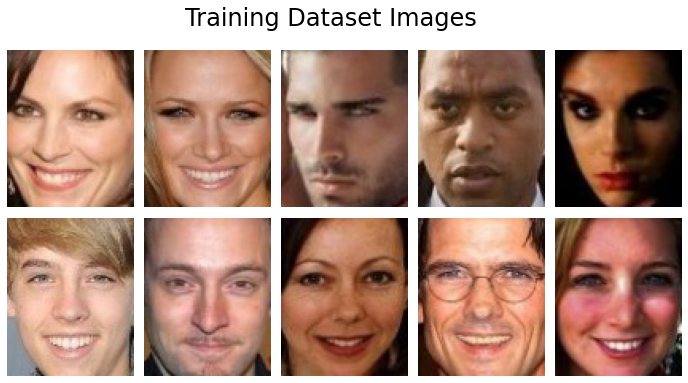

In [8]:
# reading male training images
male_train_dir = 'Data/dataset1/male/*.jpg'
male_train_images = imread_collection(male_train_dir)

# reading female training images
female_train_dir = 'Data/dataset1/female/*.jpg'
female_train_images = imread_collection(female_train_dir)

# concatenating the male and female images into a single matrix
train_images = np.row_stack((np.array(male_train_images), np.array(female_train_images)))

print("Total Female class instances:", len(male_train_images))
print("Total Male class instances:", len(female_train_images))
print("Total train instances:", len(train_images))

diplay_sample_images(train_images, 2, 5, "Training Dataset Images")

Preparing labels and shuffling dataset. 

In [9]:
image_width = 80
image_height = 100
channels = 3

number_of_data_instances = len(train_images)

# normalizing
X_train = train_images / 255.

# y lables for images (0 for Male class, 1 for Female Class)
male_train_labels = np.zeros((len(male_train_images), 1), dtype=np.int)
female_train_labels = np.ones((len(female_train_images), 1), dtype=np.int)
y_train = np.row_stack((male_train_labels, female_train_labels))

# shuffle the data instances
permuations = np.random.permutation(number_of_data_instances)
X_train = np.take(X_train, permuations, axis=0)
y_train = np.take(y_train, permuations, axis=0)

print(X_train.shape)
print(y_train.shape)

(11649, 100, 80, 3)
(11649, 1)


### Test data


The test data contains total of 1000 images. Half of these belongs to male class and other half belongs to female class. Note that these images are little different than the images we encounterd in Part A. Again note that these are more general pictures which are not cropped into the faces and they include some backgroud pixels as well. 

Total Female class instances: 500
Total Male class instances: 500
Total Test Images: 1000


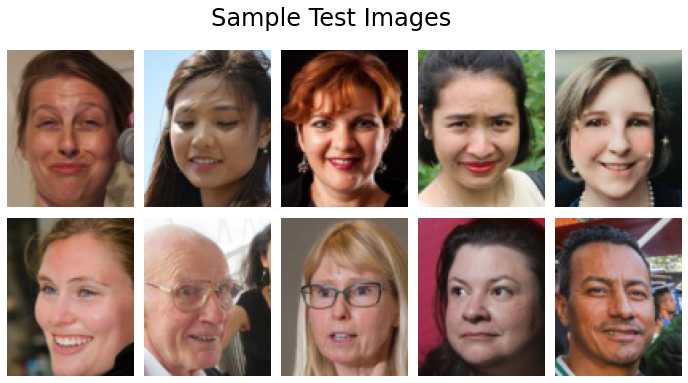

In [10]:
# reading male test images
male_test_dir = 'Data/dataset2/male/*.jpg'
male_test_images = imread_collection(male_test_dir)

# reading female test images
female_test_dir = 'Data/dataset2/female/*.jpg'
female_test_images = imread_collection(female_test_dir)

# concatenating it into a single matrix
test_images = np.row_stack((np.array(male_test_images), np.array(female_test_images)))

print("Total Female class instances:", len(male_test_images))
print("Total Male class instances:", len(female_test_images))
print("Total Test Images:", len(test_images))

diplay_sample_images(test_images, 2, 5, "Sample Test Images")

As with the train images, we preprocess the test images into standard form. 

In [11]:
number_of_test_instances = len(test_images)

# normalizing
X_test = test_images / 255.

# y lables for images (0 for Male class, 1 for Female Class)
male_test_labels = np.zeros((len(male_test_images), 1), dtype=np.int)
female_test_labels = np.ones((len(female_test_images), 1), dtype=np.int)
y_test = np.row_stack((male_test_labels, female_test_labels))

# shuffle the data instances
permuations = np.random.permutation(number_of_test_instances)
X_test = np.take(X_test, permuations, axis=0)
y_test = np.take(y_test, permuations, axis=0)

# y_test = y_test.reshape(y_test.shape[0],)

print(X_test.shape)
print(y_test.shape)

(1000, 100, 80, 3)
(1000, 1)


Converting your lables into categorical features. Note for every label (binary) there are two entries. 

In [12]:
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=2)

print(y_train.shape)
print(y_test.shape)
print(y_train_cat.shape)
print(y_test_cat.shape)

(11649, 1)
(1000, 1)
(11649, 2)
(1000, 2)


For simple neural network models you need your images flattened out. So this code just do that.

In [13]:
X_train_flat = X_train.reshape(X_train.shape[0], image_height*image_width*channels)
X_test_flat = X_test.reshape(X_test.shape[0], image_height*image_width*channels)

print(X_train_flat.shape)
print(X_test_flat.shape)

(11649, 24000)
(1000, 24000)


# Model 1 : Neural Network from Part A

Start with the best model which you used in Part A of the assingment and try to train it on training data and test in on new test data. You will notice a considerable decrease in the accuracy of the model on the test data (training accuracy will still be high). Then play around with network structure to see if you can improve it further.

### (Graded) Define your model in Keras

- The model should have or multiple hidden layers (start with the your model from part A).
- Traing the model usng the parameters from Part A (number of layers, neurons, learning rate, optimizer, batch size etc), and report the accuracy achieved
- Experiment with the acrhiecture and training parameters and see how much you can improve the accuracy. 
- Your output run should include the run of your highest accuracy model for this task

In [14]:
model1 = None
optimizer1 = optimizers.SGD(learning_rate=0.005)

########### WRITE YOUR CODE BELOW ######
Input = tf.keras.Input(shape=(X_train_flat.shape[1],))
Hlayer1 = layers.Dense(500,activation='sigmoid')(Input)
Hlayer2 = layers.Dense(250,activation='relu')(Hlayer1)
Hlayer3 = layers.Dense(100,activation='relu')(Hlayer2)
Hlayer4 = layers.Dense(50,activation='relu')(Hlayer3)
Outlayer = layers.Dense(2,activation='softmax')(Hlayer4)

model1= tf.keras.Model(inputs = Input,outputs = Outlayer,name='best_multilayer_network')
model1.compile(loss='categorical_crossentropy',optimizer=optimizer1,metrics=['accuracy'])
########### END OF CODE ###############

model1.summary()

Model: "best_multilayer_network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 24000)]           0         
_________________________________________________________________
dense (Dense)                (None, 500)               12000500  
_________________________________________________________________
dense_1 (Dense)              (None, 250)               125250    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               25100     
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 102       
Total params: 12,156,002
Trainable params: 12,156,002
Non-trainable params: 0
_______________________________

### (Graded) Train your model

- Train the model by calling the fit function of the model you define above and pass the relevent trainign data and labels.
- Record the training history in history_model1 returned by fit function. 

In [15]:
history_model1 = None

########### WRITE YOUR CODE BELOW ######
history_model1 = model1.fit(X_train_flat,y_train_cat,epochs=10,batch_size=10)

########### END OF CODE ###############

Epoch 1/10
1165/1165 [==============================] - 6s 4ms/step - loss: 0.6195 - accuracy: 0.6404
Epoch 2/10
1165/1165 [==============================] - 4s 3ms/step - loss: 0.4713 - accuracy: 0.7792
Epoch 3/10
1165/1165 [==============================] - 4s 3ms/step - loss: 0.4042 - accuracy: 0.8186
Epoch 4/10
1165/1165 [==============================] - 4s 3ms/step - loss: 0.3756 - accuracy: 0.8328
Epoch 5/10
1165/1165 [==============================] - 4s 3ms/step - loss: 0.3295 - accuracy: 0.8569
Epoch 6/10
1165/1165 [==============================] - 4s 3ms/step - loss: 0.3166 - accuracy: 0.8620
Epoch 7/10
1165/1165 [==============================] - 4s 4ms/step - loss: 0.3036 - accuracy: 0.8739
Epoch 8/10
1165/1165 [==============================] - 4s 4ms/step - loss: 0.2888 - accuracy: 0.8787
Epoch 9/10
1165/1165 [==============================] - 4s 4ms/step - loss: 0.2817 - accuracy: 0.8818
Epoch 10/10
1165/1165 [==============================] - 4s 4ms/step - loss: 0.271

Plotting the training history. 

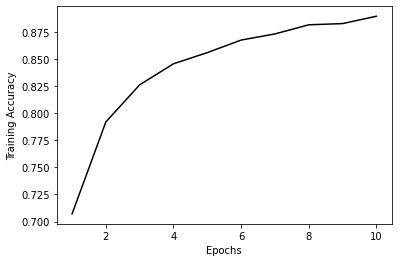

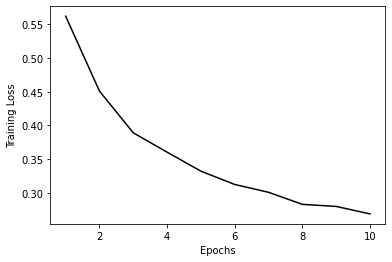

In [16]:
accuracy1 = history_model1.history['accuracy']
graph_it(accuracy1, "Training Accuracy")

loss1 = history_model1.history['loss']
graph_it(loss1, "Training Loss")

### (Graded) Evaluate your model. 

This can be done by calling the evaluate funciton of your model and the the relevent test data and labels.

In [17]:
test_loss1, test_acc1 = 0, 0

########### WRITE YOU CODE BELOW ######

test_loss1,test_acc1 = model1.evaluate(X_test_flat,y_test_cat)
########### END OF CODE ###############

print('\nTest accuracy:', test_acc1)
print("Test Loss:", test_loss1)

32/32 [==============================] - 0s 3ms/step - loss: 0.9702 - accuracy: 0.6010

Test accuracy: 0.6010000109672546
Test Loss: 0.9701718688011169


### (Graded) Write Your Results Here:

Report the accuracy achieved using your best model from Part A as well as the best results you achieved by further experimentation in this task:

Part A Model results: 62.5%


Best Model Results:65%


# Model 2 : Convolutional Neural Network (CNN)

We see that the dense layer model from Part A does not perform very well for this task so we turn to training a convolutional neural network architecture to see how much better it can perform for this task. We will again use kaggle dataset (dataset1) for training and Flickr-Faces-HQ dataset (dataset2) for test. You will see considerable performance over simple neural. CNNs are better at picking spatial patterns in the images. 

### (Graded) Define your model in Keras

- You model can use any number of layers, and any numbers of features or feature maps per layer
- Limit the layer types to Convolution 3x3 Convolution 5x5, 3x3 or 5x5 Convolutions with Stide = 2, MaxPool, and dense laysers (you might also need utility layers such as flatten)
- You goal is to come up with the architecture that gives you highest accuracy on the test data 

In [19]:
model_cnn1 = None
optimizer_cnn1 = optimizers.SGD(learning_rate=0.01)

########### WRITE YOUR CODE BELOW ######
input = layers.Input(shape =X_train.shape[1:])
layer0 = Conv2D(256,kernel_size = 3, activation='relu')(input)
pooling1 = MaxPooling2D(pool_size = 2)(layer0)
layer1 = Conv2D(128,kernel_size = 5, activation='relu')(pooling1)
pooling2 = MaxPooling2D(pool_size = 2)(layer1)
# layer2 = Conv2D(64,kernel_size = 5, activation='relu')(layer1)
# pooling3 = MaxPooling2D(pool_size = 2)(layer2)
flatten = Flatten()(pooling2)
# dense0 = Dense(500,activation='relu')(flatten)
# dense1 = Dense(250,activation='relu')(dense0)
dense2 = Dense(100,activation='relu')(flatten)
dense3 = Dense(50,activation='relu')(dense2)
output = Dense(2,activation='softmax')(dense3)

model_cnn1 = tf.keras.Model(inputs = input,outputs=output,name='CNN1')
model_cnn1.compile(loss='categorical_crossentropy',optimizer=optimizer,_cnn1,metrics=['accuracy'])

# ########### END OF CODE ###############

model_cnn1.summary()

Model: "CNN1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 80, 3)]      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 98, 78, 256)       7168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 49, 39, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 45, 35, 128)       819328    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 22, 17, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 47872)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               4787300

### (Graded) Train your model

- Train the model by calling the fit function of the model you define above and pass the relevent trainign data and labels.
- Record the training history in history_model2 returned by fit function. 

In [46]:
history_cnn1 = None

########### WRITE YOUR CODE BELOW ######
history_cnn1 = model_cnn1.fit(X_train,y_train_cat,epochs=2,batch_size=10)

########### END OF CODE ################

Epoch 1/2
1165/1165 [==============================] - 18s 15ms/step - loss: 0.6355 - accuracy: 0.6075
Epoch 2/2
1165/1165 [==============================] - 17s 15ms/step - loss: 0.2893 - accuracy: 0.8793


Plotting the training history. 

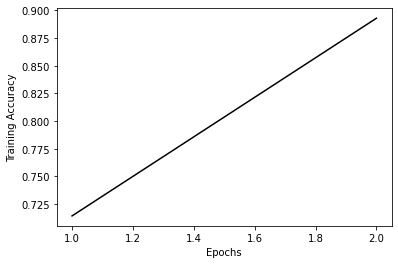

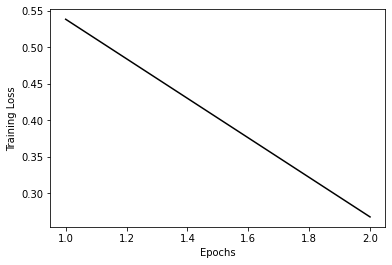

In [49]:
accuracy2 = history_cnn1.history['accuracy']
loss2 = history_cnn1.history['loss']

graph_it(accuracy2, "Training Accuracy")
graph_it(loss2, "Training Loss")

### (Graded) Evaluate your model. 

This can be done by calling the evaluate funciton of your model and the the relevent test data and labels. Experiment with CNN architecture and training parameters to find the highest accuracy version that you are able to achieve.

In [50]:
test_loss2, test_acc2 = 0, 0

########### WRITE YOUR CODE BELOW ######

test_loss2,test_acc2 = model_cnn1.evaluate(X_test,y_test_cat)

########### END OF CODE ###############

print('\nTest accuracy:', test_acc2)
print("Test Loss:", test_loss2)

32/32 [==============================] - 0s 12ms/step - loss: 0.7034 - accuracy: 0.6780

Test accuracy: 0.6779999732971191
Test Loss: 0.7034280300140381


# Model 3: Convolutional Neural Network (CNN) with Data Augmenation

As you have already seen CNN is able to do a somewhat better job, but we are still far from good accuracy. While CNNs have the ability to localoze the features better, all the training data that the CNN saw in previous section is based on tight face crops. Therefore it has not seen the variety of data which would allow it to learn more diverse features.

To hep with that we will use data augmentation in this step where for each image in our training dataset we will apply a random horizontal and vertical shift and also randomly apply a small zoom out factor. We have already provided the code to apply the augmentation, and display some example. You will see that the new training dataset with augmentation has a more varied set with faces filling different parts of the frame, thus giving the CNN the ability to learn more generalized features.

### Training data (Augmented)

This funciton will apply random augmentation to our images. Rotation, shifting, zooming etc. You are not required to change this section and can use the augmentation as given. However you are welcome to play with it if you want, since changing the augmentation can change the accuracy you will get on the test data.

In [14]:
def augment_image(image):
    image = np.expand_dims(image, 0)
    datagen = ImageDataGenerator(zoom_range=[1.3,1.0], width_shift_range=[-8,8], height_shift_range=[-5,5], fill_mode="constant", cval=i%255)
    it = datagen.flow(image, batch_size=1)
    batch = it.next()
    image_n=batch[0]
      
    return image_n.astype('uint8')

Apply data augmentation to each image in the dataset and apply the dataset. You can observe the the images now are not alike and there is some variance (distinction) in each one of them.

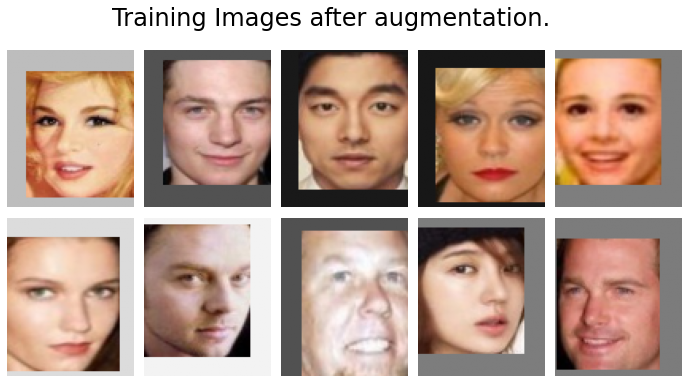

In [15]:
image_width = 80
image_height = 100
channels = 3

# initializing X_train_aug tensor, which contains augmented images
number_of_data_instances = len(train_images)
X_train_aug = np.zeros((number_of_data_instances, image_height, image_width, channels), dtype=np.int)

# applying augmentation to each image and storing it in X_train_aug
for i in range(len(train_images)):
    image = train_images[i]
    X_train_aug[i] = augment_image(image)

# normalizing
X_train_aug = X_train_aug / 255.

# display the sample of image (augmented)
diplay_sample_images(X_train_aug, 2, 5, "Training Images after augmentation.")

Preparing labels and shuffling dataset. 

In [16]:
# y lables for images (0 for Male class, 1 for Female Class)
male_train_labels = np.zeros((len(male_train_images), 1), dtype=np.int)
female_train_labels = np.ones((len(female_train_images), 1), dtype=np.int)
y_train = np.row_stack((male_train_labels, female_train_labels))

# shuffle the data instances
permuations = np.random.permutation(number_of_data_instances)
X_train_aug = np.take(X_train_aug, permuations, axis=0)
y_train = np.take(y_train, permuations, axis=0)

# y_train = y_train.reshape(y_train.shape[0],)

print(X_train_aug.shape)
print(y_train.shape)

(11649, 100, 80, 3)
(11649, 1)


### (Graded) Define your model in Keras

- You model can use any number of layers, and any numbers of features or feature maps per layer
- Limit the layer types to Convolution 3x3 Convolution 5x5, 3x3 or 5x5 Convolutions with Stide = 2, MaxPool, and dense laysers (you might also need utility layers such as flatten)
- You goal is to come up with the architecture that gives you highest accuracy on the test data using the augmanted training data.
- Note that the CNN architecture that gave you best performance in previous section may or may not be the best arhitecture for this section

In [27]:
model_cnn2 = None
optimizer_cnn2 = optimizers.SGD(learning_rate=0.01)

########### WRITE YOUR CODE BELOW ######
input = layers.Input(shape =X_train.shape[1:])
layer0 = Conv2D(32,kernel_size = 5, activation='relu')(input)
pooling2 = MaxPooling2D(pool_size = 2)(layer0)
layer1 = Conv2D(64,kernel_size = 5,activation='relu')(pooling2)
# layer2 = Conv2D(64,kernel_size = 5, activation='relu')(layer1)
pooling3 = MaxPooling2D(pool_size = 2)(layer1)
flatten = Flatten()(pooling3)
# dense0 = Dense(500,activation='relu')(flatten)
dense1 = Dense(64,activation='relu')(flatten)
dense3 = Dense(32,activation='relu')(dense1)
output = Dense(2,activation='softmax')(dense3)

model_cnn2 = tf.keras.Model(inputs = input,outputs=output,name='CNN1')
model_cnn2.compile(loss='categorical_crossentropy',optimizer=optimizer_cnn2,metrics=['accuracy'])

# ########### END OF CODE ###############

model_cnn2.summary()

Model: "CNN1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 100, 80, 3)]      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 96, 76, 32)        2432      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 48, 38, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 44, 34, 64)        51264     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 22, 17, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 23936)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                1531968

### (Graded) Train your model

- Train the model by calling the fit function of the model you define above and pass the relevent trainign data and labels.
- Record the training history in history_cnn returned by fit function. 

In [28]:
history_cnn2 = None

########### WRITE YOUR CODE BELOW ######
history_cnn2 = model_cnn2.fit(X_train_aug,y_train_cat,epochs=15)

########### END OF CODE ###############

Epoch 1/15
365/365 [==============================] - 4s 9ms/step - loss: 0.6947 - accuracy: 0.4970
Epoch 2/15
365/365 [==============================] - 3s 9ms/step - loss: 0.6938 - accuracy: 0.4956
Epoch 3/15
365/365 [==============================] - 3s 9ms/step - loss: 0.6932 - accuracy: 0.5083
Epoch 4/15
365/365 [==============================] - 3s 9ms/step - loss: 0.6932 - accuracy: 0.4994
Epoch 5/15
365/365 [==============================] - 3s 9ms/step - loss: 0.6930 - accuracy: 0.5146
Epoch 6/15
365/365 [==============================] - 3s 9ms/step - loss: 0.6934 - accuracy: 0.5015
Epoch 7/15
365/365 [==============================] - 3s 9ms/step - loss: 0.6930 - accuracy: 0.5108
Epoch 8/15
365/365 [==============================] - 3s 9ms/step - loss: 0.6927 - accuracy: 0.5167
Epoch 9/15
365/365 [==============================] - 3s 9ms/step - loss: 0.6925 - accuracy: 0.5166
Epoch 10/15
365/365 [==============================] - 3s 9ms/step - loss: 0.6926 - accuracy: 0.5166

Plotting the training history. 

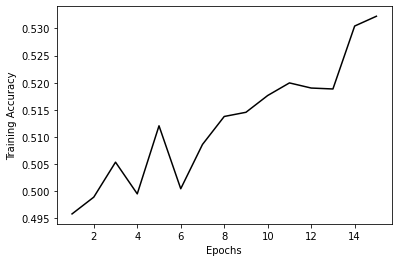

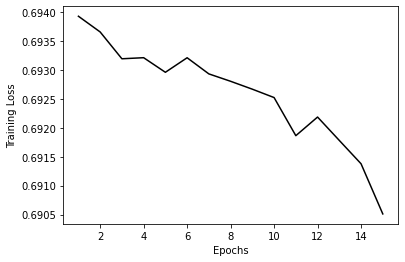

In [29]:
accuracy3 = history_cnn2.history['accuracy']
loss3 = history_cnn2.history['loss']

graph_it(accuracy3, "Training Accuracy")
graph_it(loss3, "Training Loss")

### (Graded) Evaluate your model. 

This can be done by calling the evaluate funciton of your model and the the relevent test data and labels. <b>You should be able to acheive alteast a test accuracy of 80% with data augmentation.</b> However you should strive to achieve as high an accuracy as you can since <b>your grade for the HW depends on the accuracy that you are able to achieve</b>. Experiment with CNN architecture, and training parameters to get the highest possible accuracy (you can also change the data augmentation if you want, thoguh it is not required). 

In [30]:
test_acc3, test_loss3 = 0, 0

########### WRITE YOUR CODE BELOW ######

test_loss3,test_acc3 = model_cnn2.evaluate(X_test,y_test_cat)
########### END OF CODE ###############

print('\nTest accuracy:', test_acc3)
print("Test Loss:", test_loss3)

32/32 [==============================] - 0s 6ms/step - loss: 0.6904 - accuracy: 0.5080

Test accuracy: 0.5080000162124634
Test Loss: 0.6904305219650269
